In [56]:
import pandas as pd
import re
import spacy
import plac
from pathlib import Path
from spacy.util import minibatch, compounding
from __future__ import unicode_literals, print_function
import csv
import src.dataready as dataready
import src.train as train

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import savefig

In [7]:
df = pd.read_csv('src/data.csv',)

In [28]:
with open('src/data.csv', 'r') as file:
    rea = csv.reader(file,delimiter='\t')
    for row in rea:
        print(row)

In [33]:
csv.DictReader(open('src/data.csv'))

In [34]:
categories = {
    'CHARACTERS': ['character', 'characters', 'Arthur Fleck', 'Murray Franklin', 'Sophie Dumond', 'Penny Fleck', 'mother', 'mum'],
    'TALENT': ['actor', 'actress', 'actors', 'talent', 'director', 'Joaquin Phoenix', '#JoaquinPhoenix', 'Robert De Niro', 'Zazie Beetz', 'Frances Conroy', 'Todd Philips'],
    'PLOT': ['plot', 'frame', 'scene', 'scenes'],
    'TICKETS': ['ticket', 'tickets', 'presale'],
    'SOUNDTRACK': ['music', 'song'],
    'SPECIAL EFFECTS': ['FX', 'visual effects', 'graphics', 'postproduction'],
    'COSTUME DESIGN': ['costum', 'costumes', 'costume designer'],
    'HYPE': ['hype', 'hyyyype', 'amazing', 'awesome', 'desire', 'desires', 'premiere', 'Cant wait'],
    'BOX OFFICE': ['box office'],
    'REVIEWS': ['review', 'reviews'],
    'TRAILER':['trailer', 'trailers']
}

In [ ]:
categ = pd.DataFrame(categories)
categ.to_pkl

In [40]:
import pickle
# write python dict to a file

output = open('myfile.pkl', 'wb')
pickle.dump(categories, output)
output.close()
# read python dict back from the file
pkl_file = open('myfile.pkl', 'rb')
mydict2 = pickle.load(pkl_file)
pkl_file.close()

In [44]:
df = pd.read_csv('input/#jokermovie.csv')

In [48]:
categories = df['category'].value_counts()

In [49]:
categories

TALENT        3022
HYPE           518
CHARACTERS     410
REVIEWS        278
TICKETS         82
BOX OFFICE      44
TRAILER         37
PLOT             2
Name: category, dtype: int64

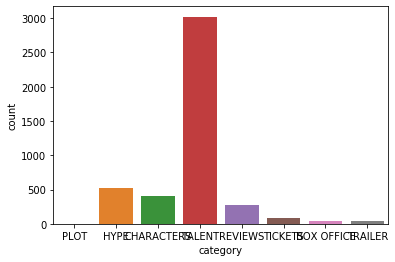

In [59]:
p = sns.countplot(data=df, x = 'category')
plt.savefig('barcategories')

In [65]:
df.date.dt.day

AttributeError: Can only use .dt accessor with datetimelike values

In [66]:
df['date']= pd.to_datetime(df['date']) 

In [67]:
df['date']

0       2019-10-05 23:59:56+00:00
1       2019-10-05 23:59:56+00:00
2       2019-10-05 23:59:49+00:00
3       2019-10-05 23:59:30+00:00
4       2019-10-05 23:59:14+00:00
                   ...           
20759   2019-10-04 17:25:06+00:00
20760   2019-10-04 17:25:05+00:00
20761   2019-10-04 17:25:03+00:00
20762   2019-10-04 17:25:01+00:00
20763   2019-10-04 17:25:00+00:00
Name: date, Length: 20764, dtype: datetime64[ns, UTC]

In [69]:
pd.merge([df,df['date']])

TypeError: merge() missing 1 required positional argument: 'right'